In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_cc_info = pd.read_csv(r"cc_info.csv")
df_transactions = pd.read_csv(r"transactions.csv")

In [3]:
df_cc_info.isna().sum()

credit_card          0
city                 0
state                0
zipcode              0
credit_card_limit    0
dtype: int64

In [4]:
df_transactions.isna().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
dtype: int64

In [5]:
df = df_transactions.merge(df_cc_info, on='credit_card')

In [6]:
df.head(10)

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000
5,1003715054175576,2015-10-17 21:28:57,121.60,-80.243565,40.260887,Houston,PA,15342,20000
6,1003715054175576,2015-08-29 18:34:04,122.65,-80.238186,40.245928,Houston,PA,15342,20000
7,1003715054175576,2015-08-14 21:34:39,98.00,-80.244063,40.249143,Houston,PA,15342,20000
8,1003715054175576,2015-09-17 19:20:37,95.20,-2.833179,34.745015,Houston,PA,15342,20000
9,1003715054175576,2015-09-11 18:59:04,57.95,-80.287528,40.267874,Houston,PA,15342,20000


In [7]:
df.shape

(294588, 9)

<Axes: xlabel='state'>

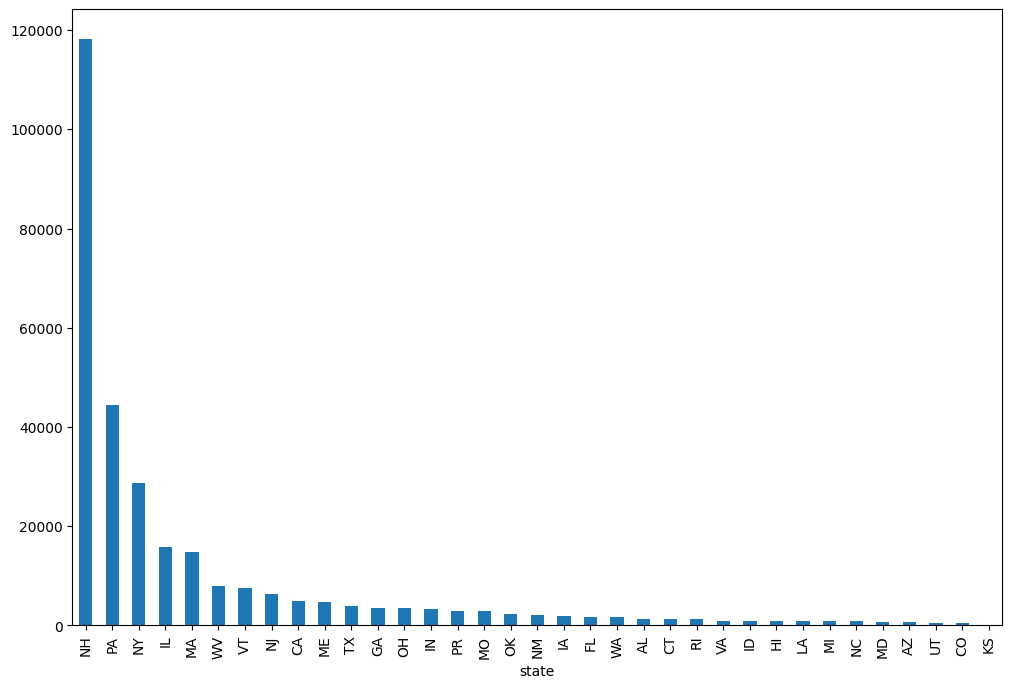

In [8]:
df['state'].value_counts().plot(kind='bar', figsize=(12,8))

In [28]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Print the correlation matrix
print(correlation_matrix)


                           credit_card  transaction_dollar_amount      Long  \
credit_card                   1.000000                   0.009553 -0.014723   
transaction_dollar_amount     0.009553                   1.000000  0.005647   
Long                         -0.014723                   0.005647  1.000000   
Lat                          -0.026233                  -0.003378 -0.090308   
zipcode                       0.023004                  -0.005318 -0.499151   
credit_card_limit             0.011901                   0.188185  0.001861   

                                Lat   zipcode  credit_card_limit  
credit_card               -0.026233  0.023004           0.011901  
transaction_dollar_amount -0.003378 -0.005318           0.188185  
Long                      -0.090308 -0.499151           0.001861  
Lat                        1.000000 -0.309885          -0.020188  
zipcode                   -0.309885  1.000000           0.011202  
credit_card_limit         -0.020188  0.01120

<Axes: >

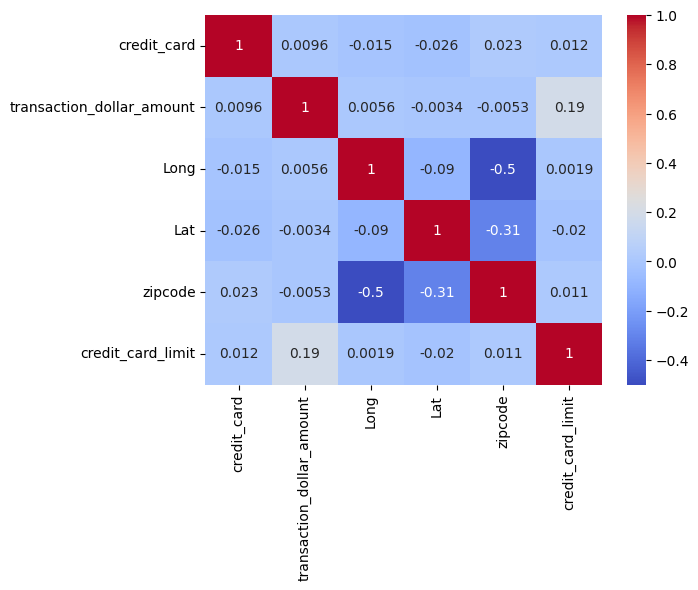

In [29]:
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
feature_columns = ['transaction_dollar_amount', 'Long', 'Lat', 'credit_card_limit', 'zipcode']

scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

The idea is to use the clustering result to identify potentially fraudulent transactions. By assuming that the cluster with the highest average transaction amount is most likely to be fraudulent, the code labels all transactions in that cluster as fraudulent (1) and all other transactions as non-fraudulent (0). This simple heuristic helps to quickly flag potential frauds based on transaction patterns observed in the data.


In [32]:
n_clusters = 2
KMeans = KMeans(n_clusters=n_clusters, random_state=42)
KMeans.fit(df[feature_columns])
df['cluster_label'] = KMeans.predict(df[feature_columns])

In [42]:
df['cluster_label']

0         0
1         0
2         0
3         0
4         0
         ..
294583    1
294584    1
294585    1
294586    1
294587    1
Name: cluster_label, Length: 294588, dtype: int32

In [39]:
cluster_fraud_label = df.groupby('cluster_label')['transaction_dollar_amount'].mean().idxmax()
print(cluster_fraud_label)

0


In [41]:
df['is_fradulent'] = df['cluster_label'].apply(lambda x: 1 if x== cluster_fraud_label else 0)
df['is_fradulent']

0         1
1         1
2         1
3         1
4         1
         ..
294583    0
294584    0
294585    0
294586    0
294587    0
Name: is_fradulent, Length: 294588, dtype: int64

In [44]:
df.head(5)

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,cluster_label,is_fradulent
0,1003715054175576,2015-09-11 00:32:40,-0.338757,-0.195624,-0.124321,0 Houston 1 ...,PA,-0.114083,0.565333,0,1
1,1003715054175576,2015-10-24 22:23:08,0.137514,-0.196623,-0.140504,0 Houston 1 ...,PA,-0.114083,0.565333,0,1
2,1003715054175576,2015-10-26 18:19:36,-0.300492,-0.197457,-0.115857,0 Houston 1 ...,PA,-0.114083,0.565333,0,1
3,1003715054175576,2015-10-22 19:41:10,0.402484,-0.195625,-0.119957,0 Houston 1 ...,PA,-0.114083,0.565333,0,1
4,1003715054175576,2015-10-26 20:08:22,-0.113818,-0.198832,-0.142989,0 Houston 1 ...,PA,-0.114083,0.565333,0,1


d:\anaconda\envs\myLLM\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


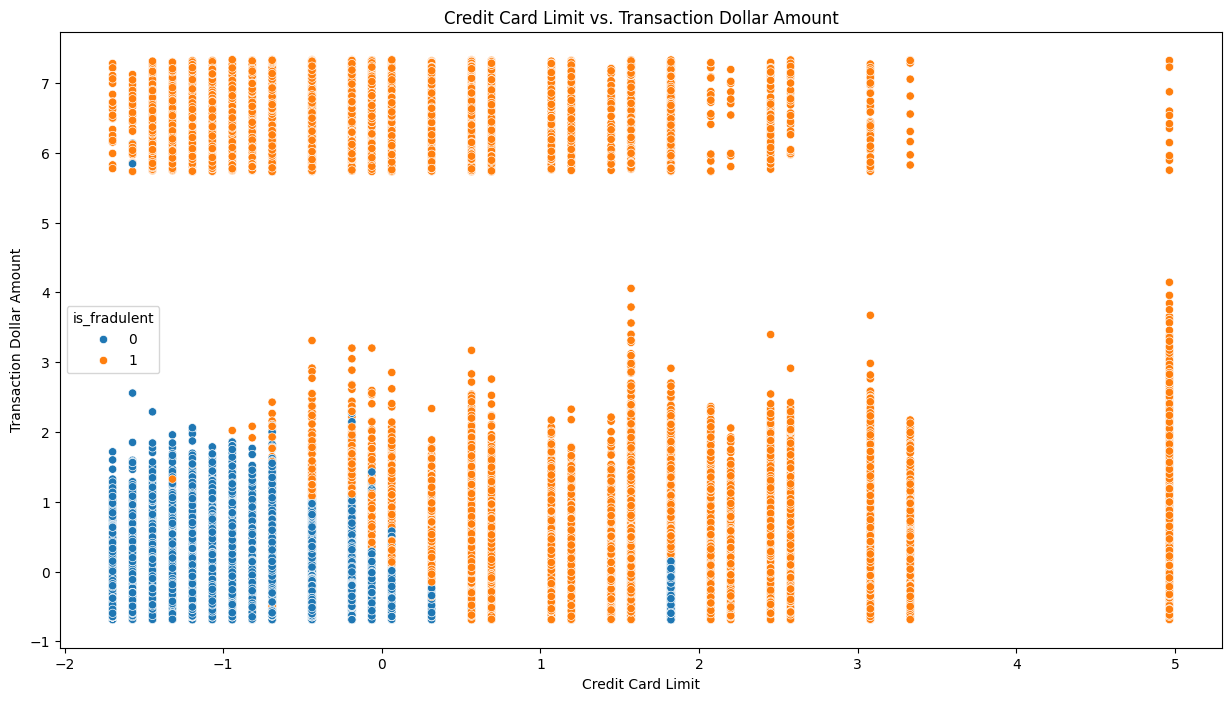

In [46]:
# Visualize Fraudulent Transactions
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='credit_card_limit', y='transaction_dollar_amount', hue='is_fradulent')
plt.title('Credit Card Limit vs. Transaction Dollar Amount')
plt.xlabel('Credit Card Limit')
plt.ylabel('Transaction Dollar Amount')
plt.show()

In [48]:
# Prepare data for model
X = df[feature_columns].values
y = df['is_fradulent'].values

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(len(feature_columns),)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

d:\anaconda\envs\myLLM\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
# Train Model
model.fit(X_train, y_train, epochs=5, batch_size=3200, verbose=0)

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Model Training Complete.")

1842/1842 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9995 - loss: 0.0043
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38730
           1       1.00      1.00      1.00     20188

    accuracy                           1.00     58918
   macro avg       1.00      1.00      1.00     58918
weighted avg       1.00      1.00      1.00     58918

Confusion Matrix:
[[38715    15]
 [   15 20173]]
Model Training Complete.
